# GeoGuessr Machine Learning-Ansatz

## Zusatzinformationen

In [21]:
base_dir = 'E:\Datasets\Strassenbilder Weltweit\Dataset_S'

## Code

### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Imports für Deep Learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
import cv2
import os

### Functions

In [16]:
def get_data(labels, appendix, cnt, img_size):
    data = [] 
    for label in labels: 
        internCounter = cnt/len(labels);
        path = os.path.join(base_dir, label, appendix, 'images')
        class_num = labels.index(label)
        for img in os.listdir(path):
            if(internCounter <= 0):
                break;
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = list(cv2.resize(img_arr, (img_size, img_size))) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
            internCounter = internCounter -1
    return data

In [17]:
def split_train_val(train, val, img_size):
    x_train = []
    y_train = []
    x_val = []
    y_val = []

    for feature, label in train:
        x_train.append(feature)
        y_train.append(label)

    for feature, label in val:
        x_val.append(feature)
        y_val.append(label)

    # Normalize the data
    x_train = np.array(x_train) / 255
    x_val = np.array(x_val) / 255

    x_train.reshape(-1, img_size, img_size, 1)
    y_train = np.array(y_train)

    x_val.reshape(-1, img_size, img_size, 1)
    y_val = np.array(y_val)
    
    return x_train, y_train, x_val, y_val

In [18]:
def generate_model(img_size, layers):
    model = Sequential()
    
    for layer in layers:
        model.add(layer)
    
    return model

In [6]:
def train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range):
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy() , metrics = ['accuracy'])

    history = model.fit(x_train,y_train,epochs = epoch_range , validation_data = (x_val, y_val))
    
    return model, history

In [7]:
def plot_history(history, epoch_range):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epoch_range)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt

def plot_history_from_xlsx(epoch_range, acc, val_acc, loss, val_loss):
    epochs_range = range(epoch_range)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt
    

In [8]:
def get_metrics(model, labels, x_val, y_val):
    predictionOdds = model.predict(x_val)
    predictions = []
    for pred in predictionOdds:
        predictions.append(list(pred).index(max(pred)))

    predictions = np.array(predictions)
    predictions = predictions.reshape(1,-1)[0]
    return classification_report(y_val, predictions, target_names = labels)

In [1]:
def run_neural_network(img_size, processed_images, train_split, labels, epoch_range, learning_rate, layers):
    train_images = int(processed_images * train_split)
    val_images = int(processed_images - train_images)
    
    train = get_data('E:\Datasets\Strassenbilder Weltweit\Dataset_S', labels, 'database', train_images, img_size)
    val = get_data('E:\Datasets\Strassenbilder Weltweit\Dataset_S', labels, 'query', val_images, img_size)
                  
    x_train, y_train, x_val, y_val = split_train_val(train, val, img_size)
    
    model = generate_model(img_size, layers)
    print(model.summary())
    
    model, history = train_model(model, learning_rate, x_train, y_train, x_val, y_val, epoch_range)
    
    metrics = get_metrics(model, labels, x_val, y_val)
    
    return history, metrics

In [77]:
def load_results():
    resultPath = os.path.join(base_dir, 'NeuralNetwork_Results.xlsx') 
    return pd.read_excel(resultPath)

In [107]:
def show_results(results, rowId, epochs):
    result = results.loc[rowId]
    
    acc = eval(result['Train Acc'])[:epochs]
    val_acc = eval(result['Val Acc'])[:epochs]
    loss = eval(result['Train Loss'])[:epochs]
    val_loss = eval(result['Val Loss'])[:epochs]
    
    return plot_history_from_xlsx(epochs, acc, val_acc, loss, val_loss)

In [2]:
def main():
    resultPath = os.path.join(base_dir, 'NeuralNetwork_Results.xlsx') 
    cities = ['berlin', 'kampala', 'melbourne', 'saopaulo', 'sf', 'tokyo']
    image_count = [100, 1000, 2000, 5000, 10000, 20000]
    resolution = [244, 450, 1000]
    learning_rate = [0.000001, 0.00001, 0.0001]
    epoch_range = 100;
    
    results = pd.DataFrame(columns=['ID', 'Netzwerk', 'Anzahl Städte', 'Anzahl Bilder', 'Bildauflösung (px)', 'Lernquote', 
                                    'Train Acc', 'Val Acc', 'Train Loss', 'Val Loss', 'Metriken'])
    results = results.set_index('ID')
    rowId = 0;
    
    for i, lastCity in enumerate(cities):
        if(i == 0): 
            continue;
        for images in image_count:
            for res in resolution:
                # needs res for initialization
                network1 = [Conv2D(32,3,padding="same", activation="relu", input_shape=(res, res, 3)), 
                                MaxPool2D(), Conv2D(32, 3, padding="same", activation="relu"), MaxPool2D(), 
                                Conv2D(64, 3, padding="same", activation="relu"), MaxPool2D(), Dropout(0.4), Flatten(), 
                                Dense(128,activation="relu"), Dense(len(cities), activation="softmax")]
                network2 = [] # TODO: choose different layers
                networks = [network1]
                for lr in learning_rate:
                    for j, network in enumerate(networks):
                        history, metrics = run_neural_network(res, images, 0.8, cities[:i+1], epoch_range, lr, network)
                        
                        results.loc[rowId] = ['Netzwerk ' + str(j+1), i+1, images, res, lr, history.history['accuracy'],
                                              history.history['val_accuracy'], history.history['loss'],
                                              history.history['val_loss'], metrics]
                        rowId = rowId + 1
    results.to_excel(resultPath)

### Execute Neural Network

In [19]:
main()

### Reload Data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 450, 450, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 225, 225, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 225, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0

C:\Python311\Lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


51/51 [==============================] - 76s 1s/step - loss: 1.7927 - accuracy: 0.1854 - val_loss: 1.7757 - val_accuracy: 0.2736
Epoch 2/5
51/51 [==============================] - 73s 1s/step - loss: 1.7732 - accuracy: 0.2191 - val_loss: 1.7601 - val_accuracy: 0.3134
Epoch 3/5
51/51 [==============================] - 72s 1s/step - loss: 1.7568 - accuracy: 0.2815 - val_loss: 1.7436 - val_accuracy: 0.3383
Epoch 4/5
51/51 [==============================] - 72s 1s/step - loss: 1.7350 - accuracy: 0.3265 - val_loss: 1.7272 - val_accuracy: 0.3632
Epoch 5/5
13/13 [==============================] - 3s 224ms/step


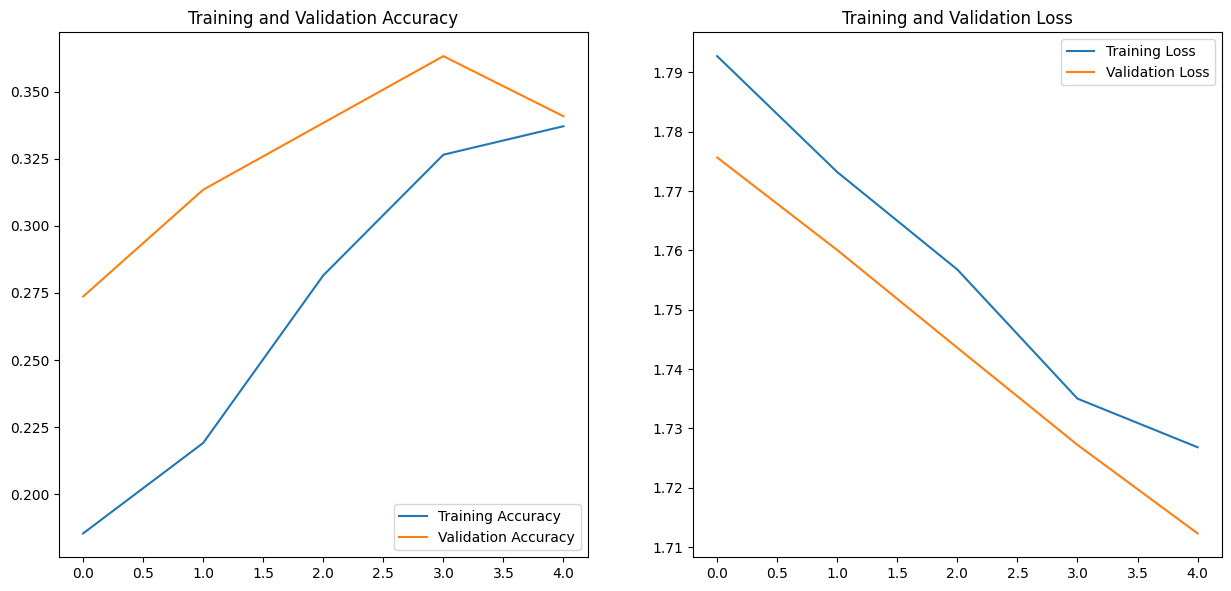

In [112]:
res = load_results()

show_results(res, 0, 5)